In [1]:
from math import *
import pandas as pd
import numpy as np
import copy  # deep copy objects

In [2]:
class DeviceInfo():
    def __init__(self, sm_num=0, sharedmem_per_sm=0, reg_per_sm=0, maxthreads_per_sm=0):
        self.sm_num = sm_num
        self.sharedmem_per_sm = sharedmem_per_sm # bytes
        self.reg_per_sm = reg_per_sm
        self.maxthreads_per_sm = maxthreads_per_sm
        
class KernelInfo():
    def __init__(self, blockDim=0, gridDim=0, reg_per_thread=0, sharedmem_per_blk=0, runtime_ms = 0, start = 0):
        self.blockDim = blockDim
        self.gridDim = gridDim
        self.reg_per_thread = reg_per_thread
        self.sharedmem_per_blk =  sharedmem_per_blk
        self.runtime_ms = runtime_ms
        self.start_ms = start

In [3]:
def MaxBLK_Per_SM(Gpu, Kern):
    """
    Compute the max blocks on one SM
    """
    warp_size = 32
    DeviceLimit = Gpu.maxthreads_per_sm / 32
    
    blocks_by_sm = DeviceLimit
    
    if Kern.sharedmem_per_blk > 0:
        blocks_by_sm = floor(Gpu.sharedmem_per_sm / float(Kern.sharedmem_per_blk)) # int operation
        
    blocks_by_reg = floor(Gpu.reg_per_sm / float(Kern.reg_per_thread * Kern.blockDim))
    
    blocks_by_threads = floor(Gpu.maxthreads_per_sm / float(Kern.blockDim))
    
    # maxblks_per_sm
    return min([blocks_by_sm, blocks_by_reg, blocks_by_threads])

In [4]:
def compute_avgblktime(Gpu, kernel):
    max_blk_per_sm = MaxBLK_Per_SM(Gpu, kernel)
    print('max blk per sm = {}'.format(max_blk_per_sm))
    
    block_per_iteration = Gpu.sm_num * max_blk_per_sm
    iterations = ceil(kernel.gridDim / block_per_iteration) # total iterations
    avg_blk_time = kernel.runtime_ms / float(iterations)
    
    return avg_blk_time

### Setup GPU info

In [5]:
gtx950 = DeviceInfo()
gtx950.sm_num = 2
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

### Setup kernel info

In [6]:
# simulate kernel number
kernel_num = 2

kernels = [KernelInfo() for i in range(kernel_num)]

kernels[0].blockDim = 512
kernels[0].gridDim = 10
kernels[0].reg_per_thread = 28
kernels[0].sharedmem_per_blk= 0
kernels[0].runtime_ms = 0.057249
kernels[0].start_ms = 0.0                                      # run the kernel at the beginning  

kernels[1].blockDim = 512
kernels[1].gridDim = 10
kernels[1].reg_per_thread = 28
kernels[1].sharedmem_per_blk= 0
kernels[1].runtime_ms = 0.057249 * 0.5   # assume half runtime
# kernels[1].start_ms = kernels[0].start_ms + kernels[0].runtime_ms * 0.5  # run the kernel after kernel 0
kernels[1].start_ms = kernels[0].start_ms + kernels[0].runtime_ms * 0.7  # run the kernel after kernel 0

# kernels[2].blockDim = 512
# kernels[2].gridDim = 10
# kernels[2].reg_per_thread = 28
# kernels[2].sharedmem_per_blk= 0
# kernels[2].runtime_ms = 0.057249 * 2  # assume x2 runtime
# kernels[1].start_ms = kernels[1].start_ms + kernels[1].runtime_ms    # run after kernel 1

### compute average block execution time

In [7]:
avg_blk_time_list = []

for kid in range(kernel_num):
    avg_blk_time_list.append(compute_avgblktime(gtx950, kernels[kid]))

max blk per sm = 4.0
max blk per sm = 4.0


In [8]:
avg_blk_time_list

[0.0286245, 0.01431225]

### Now we model the multiple kernel concurrent execution time

In [9]:
class sm_stat:
    def __init__(self, thread=0, reg=0, sharedmem = 0, full=0, batch = 1):
        self.thread = thread
        self.reg= reg
        self.sharedmem = sharedmem
        self.full = full
        self.batch = batch

    def init(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch = 1
    
    def replenish(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch += 1 # add
        
    def Rm(self, Kern):
        """
        Remove the kernel block occupied resource by adding them back.
        """
        self.thread += Kern.blockDim
        self.reg += Kern.reg_per_thread * Kern.blockDim
        self.sharedmem += Kern.sharedmem_per_blk

    def Allocate_block(self, Kern):
        self.thread -= Kern.blockDim
        self.reg -= Kern.reg_per_thread * Kern.blockDim
        self.sharedmem -= Kern.sharedmem_per_blk

        
def check_sm_resource(current_sm, block_info):
    enough_thread = current_sm.thread >= block_info.blockDim
    enough_reg = current_sm.reg >= (block_info.reg_per_thread * block_info.blockDim)
    enough_sm = current_sm.sharedmem >= block_info.sharedmem_per_blk
    
    allocate = False
    if enough_thread and enough_reg and enough_sm:
        allocate = True
    
    return allocate

In [10]:
def Search_block_start(df_sm_trace, current_kernel_id):
    """
    Read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
    """
    
    #df_active = df_sm_trace.loc[(df_sm_trace['active'] == 1) & (df_sm_trace['kernel_id'] == current_kernel_id)]
    df_active = df_sm_trace.loc[df_sm_trace['active'] == 1]
    
       
    if not df_active.empty:
        blk2start = df_active['block_start'].max() # find the closest block

        df_active_current_kernel = df_active.loc[df_active['kernel_id'] == current_kernel_id]
        if not df_active_current_kernel.empty:
            blk2start = df_active_current_kernel['block_start'].max()  # find the closest blk for current kernel
    
        return blk2start
    else:
        # when, on current sm, all the blocks are done/de-activated
        # warning!!!
        return 0.0

### Modeling the execution and record the trace

In [11]:
# init SM status
sm_num = gtx950.sm_num
sms = [sm_stat() for i in range(sm_num)]

for i in range(sm_num):
    sms[i].init(gtx950)

In [12]:
# a trace table to record all the block trace: using pd dataframe
trace_table = pd.DataFrame(columns=['sm_id', 'block_id', 'block_start', 'block_end', 'batch_id', 'kernel_id', 'active'])

# have a trace table for each sm
sm_trace = [trace_table for x in range(gtx950.sm_num)]

In [13]:
# print len(sm_trace)
# print sm_trace[0]

### run the 1st kernel

In [14]:
# kern = kernels[0] # schedule current kernel on the device
# kernel_blocks = int(kern.gridDim) # total block for current kern
# print kernel_blocks
# kern_start = kern.start_ms
# print kern_start

In [15]:
def find_sm2start(sm_trace_list, kern_start):
    sm_num = len(sm_trace_list)
    
    AfterPrevKern = False
    
    empSM = 0
    # case 1) there are no trace on each sm
    for df_sm in sm_trace_list:
        if df_sm.empty:
            empSM = empSM + 1 # do nothing

    if empSM == sm_num:
        return 0, AfterPrevKern       
    
    # case 2） there are traces: 
    # by the time where the kernel starts, all the blocks are done already, use sm 0
    max_t = 0
    for df_sm in sm_trace_list:
        cur_max = df_sm.block_end.max()
        if cur_max > max_t:
            max_t = cur_max
            
    if max_t <= kern_start:
        AfterPrevKern = True
        return 0, AfterPrevKern
    else:
        # case 3) : check currently active blocks
        df_sm = sm_trace_list[0]
        df_activeblk = df_sm.loc[df_sm['active'] == 1]
        min_t = df_activeblk.block_end.min()
        target_sm = 0
        
        for i in range(1,sm_num):
            df_sm = sm_trace_list[i]
            df_activeblk = df_sm.loc[df_sm['active'] == 1]
            sm_blk_min = df_activeblk.block_end.min()
            if sm_blk_min < min_t:
                min_t = sm_blk_min
                target_sm = i
                
        return target_sm, AfterPrevKern

In [ ]:
def cke_model(sms_, sm_trace_, kernels_):
    # deep copy the input
    # we need to return the resource and trace for each sm after modeling
    

In [16]:
# go through each kernel
for i in range(kernel_num):
    kern = kernels[i] # schedule current kernel on the device
    
    kernel_blocks = int(kern.gridDim) # total block for current kern
#     print kernel_blocks
    
    kern_start = kern.start_ms
    print('kern-{}: start {}'.format(i, kern_start))
    
    # 1) find the which sm to start
    # 2) compute whether kernel_start happens before previous kernel ends or not
    sm2start, AfterPrevKern = find_sm2start(sm_trace, kern_start)
    print('sm2start : {}, AfterPrevKern {}'.format(sm2start, AfterPrevKern))

    #---------------------------------------------------------
    # Run after previous kernel
    #---------------------------------------------------------
    if AfterPrevKern:
        # deactivate all the previous active blocks
        myid = 0
        for df_sm in sm_trace:
            df_activeblk = df_sm.loc[df_sm['active'] == 1]
            for index, row in df_activeblk.iterrows():     # find the row index of active blocks
                sm_trace[myid].loc[index]['active'] = 0    # deactivate 
                sms[myid].Rm(kern)                         # free the block resource
                myid = myid + 1
                        
#         if i==1: break
        

    #---------------------------------------------------------
    # Continue current kernel
    #---------------------------------------------------------
    for bid in range(kernel_blocks):
        sm_id = (bid + sm2start) % sm_num
        print('sm_id {} '.format(sm_id))

        to_allocate_another_block = check_sm_resource(sms[sm_id], kern)
        print('to_allocate_another_block {}'.format(to_allocate_another_block)) 

        #----------------------------------
        # there is enough resource to host the current block
        #----------------------------------
        if to_allocate_another_block == True:
            sms[sm_id].Allocate_block(kern)  # deduct resources on the current sm

            #---------------------------------------
            # register the block in the trace table
            #---------------------------------------
            block_start = None
            
            offset = 0.0
            if AfterPrevKern and bid < sm_num:  # Noted: only the 1st block will adjut the kern_start
                offset = kern_start

            # if current sm trace table is empty, start from 0
            # else find the blocks that will end soon, and retire them
            if sm_trace[sm_id].empty:
                block_start = 0
            else:
                # read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
                block_start = Search_block_start(sm_trace[sm_id], i) + offset


            block_end = block_start + avg_blk_time_list[i]
            
            print('kern {} : block_start: {}, block_end: {}, block_start {}'.format(i, 
                                                            block_start, block_end, 
                                                            Search_block_start(sm_trace[sm_id], i)))
#             if i==1 and bid == 8: break

#             if i==1 and bid == 0: 
#                 print('block_start {}, block_end {}, kern_start {}'.format(block_start, block_end, kern_start))
#                 break

            # add the current block info to the current sm
            sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                      'block_id': bid, 
                                                      'block_start': block_start, # add the kern stat
                                                      'block_end' : block_end,
                                                      'batch_id': sms[sm_id].batch,
                                                      'kernel_id': i,
                                                      'active': 1}, ignore_index=True)

        #-------------------------------------------
        # There is no more resources to host the blk, consider SM is full now
        # we need to (1) decide how many blks to retire (2) when to start current blk
        if to_allocate_another_block == False:
            # find out the active blocks on current sm
            df_sm = sm_trace[sm_id]
            df_activeblk = df_sm.loc[df_sm['active'] == 1]
            df_loc = df_activeblk.copy(deep=True)

            cur_activeblk_num = df_activeblk.shape[0]

                
            for ii in range(cur_activeblk_num):
                # find out blocks ending soon
                blkend_min = df_loc['block_end'].min()
                df_blk2end = df_loc.loc[df_loc['block_end'] == blkend_min]

                # retire the blocks
                for index, row in df_blk2end.iterrows():
                    sm_trace[sm_id].loc[index]['active'] = 0 
                    sms[sm_id].Rm(kern) # free the block resource

                # enough to allocate a current block
                if check_sm_resource(sms[sm_id], kern):
                    sms[sm_id].Allocate_block(kern)

                    block_start = blkend_min # when prev blks end, current block starts
                    block_end = block_start + avg_blk_time_list[i]     # add avgblktime for currrent kernel
                    break # jump out of the loop
                else:
                    # not enough to allocat another block, remove
                    df_loc = df_sm.loc[df_sm['active'] == 1]

#             print('kernel {}'.format(i))
#             if i==1 and bid == 8: break
                
            # update the trace table
            sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                      'block_id': bid, 
                                                      'block_start': block_start,
                                                      'block_end' : block_end,
                                                      'batch_id': sms[sm_id].batch,
                                                      'kernel_id': i,
                                                      'active': 1}, ignore_index=True)
                
#         if bid == 9: break
#     if i == 1: break

kern-0: start 0.0
sm2start : 0, AfterPrevKern False
sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0, block_end: 0.0286245, block_start 0.0
sm_id 1 
to_allocate_another_block True
kern 0 : block_start: 0, block_end: 0.0286245, block_start 0.0
sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 1 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 1 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 1 
to_allocate_another_block True
kern 0 : block_start: 0.0, block_end: 0.0286245, block_start 0.0
sm_id 0 
to_allocate_another_block False
sm_id 1 
to_allocate_another_block False
kern-1: start 0.0400743
sm2sta

In [17]:
sm_trace[0]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active
0,0.0,0.0,0.000000,0.028625,1.0,0.0,0.0
1,0.0,2.0,0.000000,0.028625,1.0,0.0,0.0
2,0.0,4.0,0.000000,0.028625,1.0,0.0,0.0
3,0.0,6.0,0.000000,0.028625,1.0,0.0,0.0
4,0.0,8.0,0.028625,0.057249,1.0,0.0,1.0
5,0.0,0.0,0.028625,0.042937,1.0,1.0,0.0
6,0.0,2.0,0.028625,0.042937,1.0,1.0,0.0
7,0.0,4.0,0.028625,0.042937,1.0,1.0,0.0
8,0.0,6.0,0.042937,0.057249,1.0,1.0,1.0
9,0.0,8.0,0.042937,0.057249,1.0,1.0,1.0


In [18]:
sm_trace[1]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active
0,1.0,1.0,0.000000,0.028625,1.0,0.0,0.0
1,1.0,3.0,0.000000,0.028625,1.0,0.0,0.0
2,1.0,5.0,0.000000,0.028625,1.0,0.0,0.0
3,1.0,7.0,0.000000,0.028625,1.0,0.0,0.0
4,1.0,9.0,0.028625,0.057249,1.0,0.0,1.0
5,1.0,1.0,0.028625,0.042937,1.0,1.0,0.0
6,1.0,3.0,0.028625,0.042937,1.0,1.0,0.0
7,1.0,5.0,0.028625,0.042937,1.0,1.0,0.0
8,1.0,7.0,0.042937,0.057249,1.0,1.0,1.0
9,1.0,9.0,0.042937,0.057249,1.0,1.0,1.0


### plot

/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


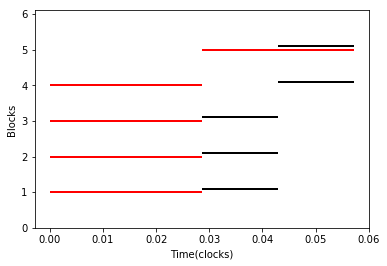

In [19]:
def Plot_sm_trace(df_sm):
    import matplotlib.pyplot as plt
    
    # color to pick
    color_list = ['r', 'k', 'b', 'g', 'c', 'm', 'y', '#cc0000', '#cc6600', 'cc9900',
                  '#cc3300', '#cccc00', '#99cc00', '#66cc00', '#00cccc', '#0033cc', 
                  '#6600cc', '#cc00cc', '#ff99cc', 'ffcc00']
    
    total_color = len(color_list) 
    
    kern_ids = df_sm['kernel_id'].unique()
    
    x0_dd = {}
    x1_dd = {}
    y0_dd = {}
    
    ylim_max = 0
    
    for kid in kern_ids:
        offset = 0.1 * kid
        df_kern = df_sm.loc[df_sm['kernel_id'] == kid] # get the data for current kernel on
        df_kern['y_axis'] = pd.Series(np.arange(1,len(df_kern.index)+1) + offset, 
                                      index=df_kern.index) # adding y_axis label
    
        x0_dd[kid] = df_kern['block_start']
        x1_dd[kid] = df_kern['block_end']
        y0_dd[kid] = df_kern['y_axis']

        current_ymax = max(df_kern['y_axis']) + 1
    
        if ylim_max < current_ymax:
            ylim_max = current_ymax
    

    axes = plt.gca()
    axes.set_ylim([0, ylim_max])

    for kid in kern_ids:
        cid = int(kid) % total_color
        plt.hlines(y0_dd[kid], x0_dd[kid], x1_dd[kid], lw=2, color=color_list[cid])

    
                                
# #     plt.title('Memory Bound')
    plt.xlabel('Time(clocks)')
    plt.ylabel('Blocks')
    plt.show()
    

#---------------------
# plot
#---------------------
df_sm = sm_trace[0]

Plot_sm_trace(df_sm)